<a href="https://colab.research.google.com/github/SS-Bird/CS166-ModellingandSims/blob/main/Airport_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note that you are going to do this project in two steps. First, you are going to construct a basic implementation of the M/G/k model. You will then test and validate your model using a few specific parameter combinations, comparing the output of your simulation against values that we provide to you. Once you have confirmed that your model reproduces the expected behavior, you will modify your code to generate the extended model, described below.

# Model
A large airport operates 24 hours a day. All travelers have to go through an airport security screening before they can board their planes. At airport security, there are several queues, each with an assigned service station where travelers are asked to take off their shoes, etc., and have their carry-on bags screened.

The time between consecutive travelers joining a queue is assumed to come from an exponential distribution with a rate parameter **λ = 10** travelers per minute. Travelers join the shortest queue when they are ready to pass through security.
Under normal circumstances, a security service station spends **approximately 30 seconds per traveler** to clear them through all the security checks. There is some variation in service time and generally the time taken per traveler follows a Truncated Normal distribution with parameters $\mu_1 = 30$ seconds and $\sigma_1 = 10$ seconds. The distribution is truncated to allow for positive service times only.
To simplify this simulation (compared to the real world), we assume that only 1 traveler can be served by a security service station at one time. While a traveler is being screened, everybody behind that person has to wait in the queue.
Once you have completed this model, you will test it using specific combinations of parameter values that we will provide to you. We will also provide you with specific outputs that your simulation should produce under those parameter values.
Note that your code should be written in a way where λ, µ1, and σ1 are each set in a single location, so that it is easy to change the parameterization of the model with a single change to the code. This means easy for you, for your TAs, and your professor.

There is a small chance (3%) that a traveler will need additional screening ($p_s = 0.03$) — for example, if there is something suspicious in their luggage. This requires a senior security officer to inspect the problem and clear the traveler. The additional screening follows a Truncated Normal distribution with $\mu_2 = 2$ minutes and $\sigma_2 = 2$ minutes. (Note that 2 minutes = 120 seconds.) There is only one senior security officer at the airport, and the senior officer can inspect only one traveler at a time. While a traveler is undergoing additional screening, everybody else in the queue has to wait for the additional screening to finish.
This extension should also be written so that the values of µ2, σ2, and ps can each be modified directly in a single location. You should try setting µ2 = 0 and σ2 = 0 to confirm that this reproduces the behavior of your basic model. Similarly, setting ps = 0 should also reproduce the original model.
As part of your deliverable, you will explain the changes you made to the code to include this extension.


In [1]:
#

In [2]:
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

In [3]:

# Schedule class

class schedule:
    """
    The schedule class for the airport simulation.
    The schedule uses a priority queue to manage events in the simulation.
    We use a min heap to implement the priority queue.
    and the events are tuples of (time, event_name, function).
    """
    def __init__(self):
        self.events = []
        self.time = 0

    def add_event_after(self, duration ,event_name, function):
        """Add an event to the schedule after a certain duration."""
        event_time = self.time + duration
        heapq.heappush(self.events, (event_time, event_name, function))

    def process_next_event(self):
        """Process the next event in the schedule."""
        if self.events:
            event_time, event_name, function = heapq.heappop(self.events)
            self.time = event_time
            function()
            return event_name
        else:
            return None

# Queue class

class Queue:
    """
    A queue class for the airport simulation.
    The queue tracks the number of people in line, whether someone is being served
    and the service time distribution.
    There are dummy paremeters for extra security queue to be implemented later.
    """
    def __init__(self, service_time_dist, schedule, extra_security_queue):

        self.line_length = 0
        self.currently_serving = None
        self.service_time_dist = service_time_dist
        self.schedule = schedule
        self.waiting = []
        self.waiting_time = []

    def add_person(self, current_time):
        """add a person to the queue"""
        self.line_length += 1
        self.waiting.append(current_time)
        if not self.currently_serving:
            self.start_service(current_time)

    def start_service(self, current_time):
        """start serving the next person in line"""
        if self.line_length > 0:
            self.line_length -= 1
            self.waiting_time.append(current_time - self.waiting[0])
            self.waiting = self.waiting[1:]
            self.currently_serving = True
            service_time = self.service_time_dist()
            self.schedule.add_event_after(service_time, "service_complete", self.complete_service)


    def complete_service(self):
        """complete the service of the current person"""
        self.currently_serving = None
        self.start_service(self.schedule.time)

    def is_busy(self):
        """getter to check if the queue is busy"""
        return self.currently_serving is not None

    def __lt__(self, other):
        """less than operator for priority queue based on line length and busy status"""
        load = self.line_length + (1 if self.is_busy() else 0)
        other_load = other.line_length + (1 if other.is_busy() else 0)
        return load < other_load

# Airport Class
class Airport:
    """
    The Airport class for the airport simulation.
    The airport has multiple queues for check-in, security, and boarding.
    It also has distributions for arrival rates and service times.

    The extra security queue is a special queue for passengers who need additional screening.
    It is currently a dummy implementation. with no logic
    TODO : Implement logic for directing passengers to the extra security queue.
    """
    def __init__(self, schedule, service_time_dist, exta_security_service_time_dist,
                 arrival_rate_dist, arrival_count_dist, num_checkin_queues=3, num_security_queues=3, p_screening=0):
        self.schedule = schedule

        self.extra_security_queue = None
        self.checkin_queues = []
        for _ in range(num_checkin_queues):
            heapq.heappush(self.checkin_queues, Queue(service_time_dist, schedule, self.extra_security_queue))

        self.count_arrival_dist = arrival_count_dist
        self.arrival_rate_dist = arrival_rate_dist
        self.schedule.add_event_after(0, "passenger_arrival", self.passenger_arrival) # Schedule the first passenger arrival

        # senior TODO: Implement security and boarding logic


    def passenger_arrival(self):
        """Handle passenger arrival event"""
        # determine how many passengers arrive, this has the ability to simulate a group arrival
        # the group acts as individual passengers
        count = self.count_arrival_dist()
        # for all arriving passengers, assign them to the shortest check-in queue

        heapq.heapify(self.checkin_queues)  # Re-establish heap property

        shortest_queue = heapq.heappop(self.checkin_queues)
        for _ in range(count):
            shortest_queue.add_person(self.schedule.time)
        heapq.heappush(self.checkin_queues, shortest_queue)

        # Schedule the next passenger arrival
        next_arrival_time = self.arrival_rate_dist()
        self.schedule.add_event_after(next_arrival_time, "passenger_arrival", self.passenger_arrival)



In [4]:
def start_simulation(until, service_time_dist, exta_security_service_time_dist,
                     arrival_rate_dist, arrival_count_dist, num_checkin_queues=3, num_security_queues=3, p_screening=0.03, verbose=False):
    """Start the airport simulation until a certain time.
    inputs:
        until: float, the time to run the simulation until
        service_time_dist: function, a function that returns a random service time for check-in
        exta_security_service_time_dist: function, a function that returns a random service time for extra security
        arrival_rate_dist: function, a function that returns a random arrival time for passengers
        arrival_count_dist: function, a function that returns a random number of arriving passengers
        num_checkin_queues: int, number of check-in queues
        num_security_queues: int, number of security queues
        p_screening: float, probability of a passenger needing extra screening
        verbose: bool, whether to print verbose output
    returns:
        airport: Airport, the airport object after the simulation
    """

    schedule_obj = schedule()
    airport = Airport(schedule_obj, service_time_dist, exta_security_service_time_dist,
                      arrival_rate_dist, arrival_count_dist, num_checkin_queues, num_security_queues, p_screening=p_screening)

    # track data for analysis
    avg_queue_lengths = []
    while schedule_obj.time < until:
        event_name = schedule_obj.process_next_event()

        if verbose:
            print(f"Time: {schedule_obj.time:.2f}, Event: {event_name}, Check-in Queue Lengths: {[q.line_length for q in airport.checkin_queues]}, Extra Security Queue Length: {airport.extra_security_queue.line_length}")
            print("-" * 50)
            for time, event_name, _ in schedule_obj.events:
                print(f"  Scheduled Event - Time: {time:.2f}, Event: {event_name}")
    return airport

In [5]:
from tqdm import tqdm
def run_n_simulations(n, L=10, mu_1=0.5, sigma_1=1/6, mu_2=2, sigma_2=2, num_queues=10,
                    p_screening = 0.03, count_dist=[[1, 2, 3, 4, 5],[0.49, 0.36, 0.07, 0.07,0.01]]):
    """Run n simulations of the airport model and collect statistics.
    inputs:
        n: int, number of simulations to run
        L: float, arrival rate (mean number of arrivals per minute, exponential distribution)
        mu_1: float, mean service time for check-in (minutes, trunc normal distribution)
        sigma_1: float, stddev of service time for check-in (minutes, trunc normal distribution)
        mu_2: float, mean service time for extra security (minutes, trunc normal distribution)
        sigma_2: float, stddev of service time for extra security (minutes, trunc normal distribution)
        num_queues: int, number of check-in queues
        p_screening: float, probability of a passenger needing extra screening
        count_dist: [list, list], distribution for number of arriving passengers
    returns:
        results_avg_queue: list, average queue lengths for each simulation
        results_max_queue: list, maximum queue lengths for each simulation
        results_waiting_time: list, average waiting times for each simulation (this takes into account only the passangers who were served not the ones currenlty waiting)
    """
    # handling errors/bad parameters:
    if n <= 0:
        raise ValueError("Number of simulations n must be positive.")
    if L <= 0:
        raise ValueError("Arrival rate L must be positive.")
    if mu_1 <= 0 or sigma_1 <= 0:
        raise ValueError("Service time parameters for check-in must be positive.")
    if mu_2 < 0 or sigma_2 < 0:
        raise ValueError("Service time parameters for extra security must be positive.")
    if num_queues <= 0:
        raise ValueError("Number of queues must be positive.")
    if not (0 <= p_screening <= 1):
        raise ValueError("Probability of screening must be between 0 and 1.")
    if len(count_dist) != 2 or len(count_dist[0]) != len(count_dist[1]):
        raise ValueError("count_dist must be a list of two lists of equal length.")

    results_avg_queue = []
    results_max_queue = []
    results_waiting_time = []

    # Arrival rate: 10 travelers per minute
    def arrival_rate_dist():
        nonlocal L
        return np.random.exponential(1/L)

    def arrival_count_dist():
        # real life distribution, 49% chance of 1 traveler, 36% for 2, 7% for 3, 7% for 4
        return np.random.choice(count_dist[0], p=count_dist[1])

    # Service time: mean mu_1 minutes, stddev sigma_1 minutes, truncated for positive values
    def service_time_dist():
        nonlocal mu_1, sigma_1
        return max(0, np.random.normal(mu_1, sigma_1))  # mean mu_1 minutes, stddev sigma_1 minutes

    def extra_security_service_time_dist():
        nonlocal mu_2, sigma_2
        return max(0, np.random.normal(mu_2, sigma_2))  # mean mu_2 minutes, stddev sigma_2 minutes


    for _ in tqdm(range(n)):

        airport = start_simulation(until=60,
                                   service_time_dist=service_time_dist,
                                   exta_security_service_time_dist=extra_security_service_time_dist,
                                   arrival_rate_dist=arrival_rate_dist,
                                   arrival_count_dist=arrival_count_dist,
                                   num_checkin_queues=num_queues,
                                   num_security_queues=1, p_screening=p_screening)

        avg_checkin_queue_length = np.mean([queue.line_length for queue in airport.checkin_queues])

        results_avg_queue.append(avg_checkin_queue_length)

        max_checkin_queue_length = max([queue.line_length for queue in airport.checkin_queues])

        results_max_queue.append(max_checkin_queue_length)


        # to get waiting time, we need to go to each queue and get its array
        waiting_times = [queue.waiting_time for queue in airport.checkin_queues]

        # now we flatten the array
        waiting_times = [item for sublist in waiting_times for item in sublist]

        # sample 100 waiting times to avoid bias from large simulations
        if len(waiting_times) > 100:
            waiting_times = np.random.choice(waiting_times, 100, replace=False)

        results_waiting_time.append(np.mean(waiting_times))

    return results_avg_queue, results_max_queue, results_waiting_time

# Test Cases

In [6]:
def test_simulation(until, arrival_dist, service_dist, num_queues,
                    expected_mean, expected_CI, num_simulations = 1000):
    """test with two parameter sets and compare to expected results"""



    print(f"\nRunning simulation test for {until} minutes with {num_queues} check-in queues...")
    print(f"Parameters: arrival_dist={arrival_dist.__name__}, service_dist={service_dist.__name__}")

    # Arrival rate (total system)
    print("#"*20 + " P A R A M E T E R S " + "#"*20)
    arrival_samples = [arrival_dist() for _ in range(10000)]
    lambda_total = 1 / np.mean(arrival_samples)
    lambda_per_queue = lambda_total / num_queues
    print(f"Total arrival rate λ: {lambda_total:.2f} passengers/min")
    print(f"Arrival rate per queue: {lambda_per_queue:.2f} passengers/min")

    # Service rate
    service_samples = [service_dist() for _ in range(10000)]
    mu = 1 / np.mean(service_samples)
    service_variance = np.var(service_samples)
    C_s = np.sqrt(service_variance) / np.mean(service_samples)  # Coefficient of variation
    print(f"Service rate μ: {mu:.2f} passengers/min")
    print(f"Mean service time: {np.mean(service_samples):.2f} min")

    # Traffic intensity per queue
    rho = lambda_per_queue / mu

    if rho >= 1:
        print("WARNING: System is unstable (ρ >= 1)!")

    print("#"*40)

    all_means = []
    for _ in tqdm(range(num_simulations)):
        airport = start_simulation(until=until,
                                   service_time_dist=service_dist,
                                   exta_security_service_time_dist=service_dist,
                                   arrival_rate_dist=arrival_dist,
                                   arrival_count_dist=lambda: 1,  # single arrivals for simplicity
                                   num_checkin_queues=num_queues,
                                   num_security_queues=1, p_screening=0)
        avg_queue_length = np.mean([queue.line_length for queue in airport.checkin_queues])
        all_means.append(avg_queue_length)



    # Calculate statistics across all simulations
    CI = 1.96 * (np.std(all_means) / np.sqrt(len(all_means)))
    overall_mean = np.mean(all_means)

    print(f"\nExpected values: {expected_mean} ± {expected_CI}")
    print(f"Simulated mean queue length: {overall_mean:.2f} ± {CI:.2f}")

    if overall_mean - CI > expected_mean + expected_CI or overall_mean + CI < expected_mean - expected_CI:
        print("Warning: Simulated mean queue length is outside expected range!")

# paramter set 1:
def arrival_rate_dist():
    return np.random.exponential(1/10)  # mean inter-arrival time is 0.1 minutes

def service_time_dist():
    return np.random.uniform(0,1)  # uniform between 0 and 1 minutes


print("Parameter Set 1:")

test_simulation(100, arrival_rate_dist, service_time_dist, num_queues=6,
                 expected_mean=0.49, expected_CI=0.03)
#############################################################

# paramter set 2:
# same arrival distributions as before
def arrival_rate_dist2():
    return np.random.exponential(1/10)  # mean inter-arrival time is 0.1 minutes

def service_time_dist2():
    # write this in np
    # stats.truncnorm(-1, np.inf, loc = 1, scale = 1)
    while True:
        sample = np.random.normal(1,1)
        if sample > 0:  return sample

print("\nParameter Set 2:")
test_simulation(100, arrival_rate_dist2, service_time_dist2, num_queues=14,
                 expected_mean=0.59, expected_CI=0.02)


Parameter Set 1:

Running simulation test for 100 minutes with 6 check-in queues...
Parameters: arrival_dist=arrival_rate_dist, service_dist=service_time_dist
#################### P A R A M E T E R S ####################
Total arrival rate λ: 10.04 passengers/min
Arrival rate per queue: 1.67 passengers/min
Service rate μ: 2.00 passengers/min
Mean service time: 0.50 min
########################################


100%|██████████| 1000/1000 [00:16<00:00, 58.97it/s]



Expected values: 0.49 ± 0.03
Simulated mean queue length: 0.46 ± 0.04

Parameter Set 2:

Running simulation test for 100 minutes with 14 check-in queues...
Parameters: arrival_dist=arrival_rate_dist2, service_dist=service_time_dist2
#################### P A R A M E T E R S ####################
Total arrival rate λ: 10.11 passengers/min
Arrival rate per queue: 0.72 passengers/min
Service rate μ: 0.78 passengers/min
Mean service time: 1.28 min
########################################


100%|██████████| 1000/1000 [00:11<00:00, 85.50it/s]


Expected values: 0.59 ± 0.02
Simulated mean queue length: 0.57 ± 0.03


# Plots

In [7]:
# plot histogram of results for default values
def plot_histogram_of_simulation_results(n=1000,num_queues=10, L=10, mu_1=0.5, sigma_1=1/6, mu_2=2, sigma_2=2, p_screening = 0.03):
    """Plot histograms of simulation results for
        average queue lengths,
        maximum queue lengths, and
        average waiting times.
    """
    avg_queue_lengths, max_queue_lengths, avg_waiting_time_min = run_n_simulations(n, L=L, mu_1=mu_1, sigma_1=sigma_1, mu_2=mu_2, sigma_2=sigma_2, num_queues=num_queues, p_screening=p_screening)


    plt.figure(figsize=(10, 6), dpi=200)
    plt.hist(
        avg_queue_lengths,
        bins=20,
        alpha=0.6,
        edgecolor="black",
        label="Average Queue Length (customers)"
    )
    plt.hist(
        max_queue_lengths,
        bins=20,
        alpha=0.6,
        edgecolor="black",
        label="Maximum Queue Length (customers)"
    )

    plt.xlabel("Queue Length (customers)")
    plt.ylabel("Frequency (number of simulations)")
    plt.title("Histogram of Queue Length Metrics")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 6), dpi=200)
    plt.hist(
        avg_waiting_time_min,
        bins=20,
        alpha=0.7,
        edgecolor="black",
        label="Average Waiting Time (minutes)"
    )

    plt.xlabel("Waiting Time (minutes)")
    plt.ylabel("Frequency (number of simulations)")
    plt.title("Histogram of Average Waiting Time")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


100%|██████████| 1000/1000 [00:25<00:00, 39.47it/s]


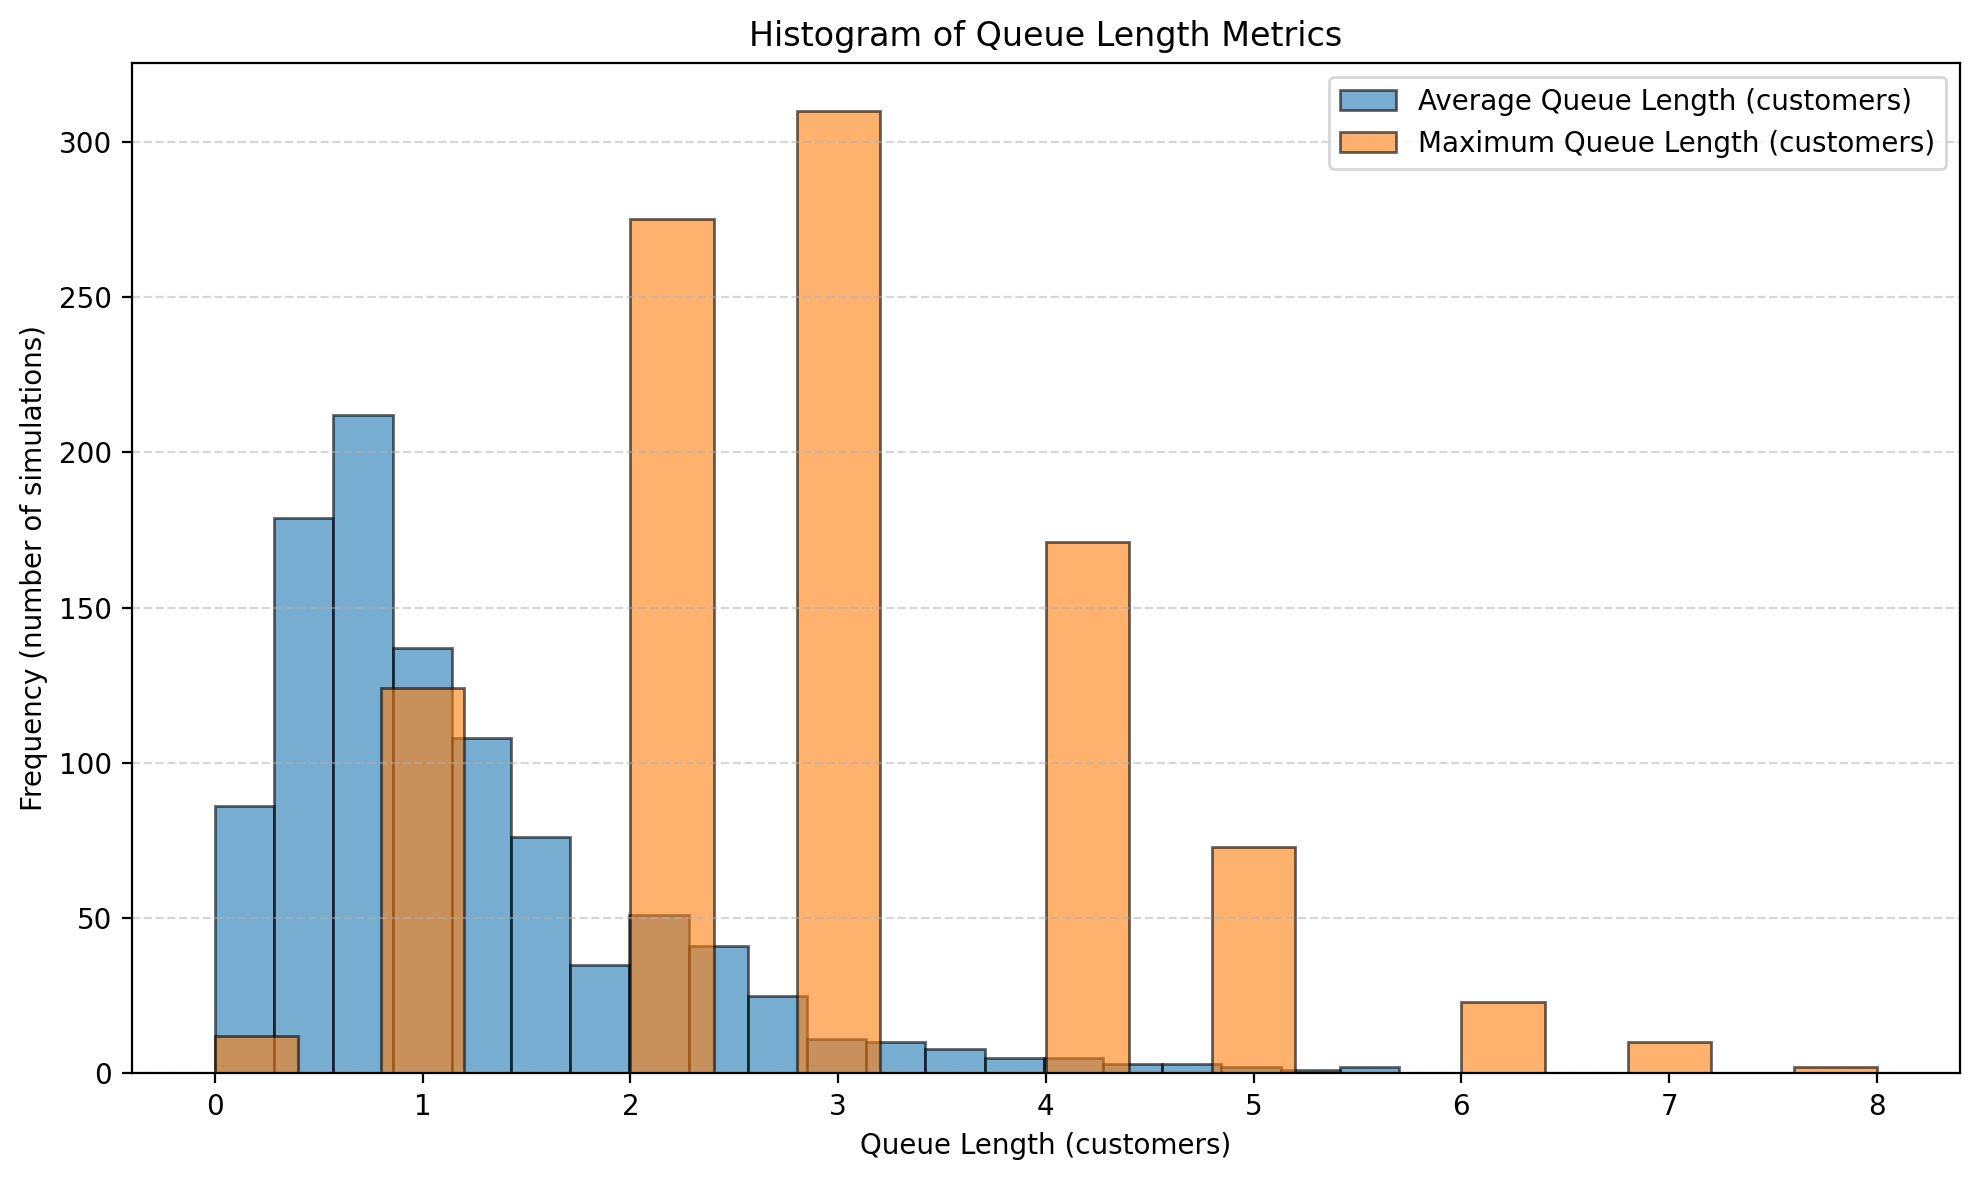

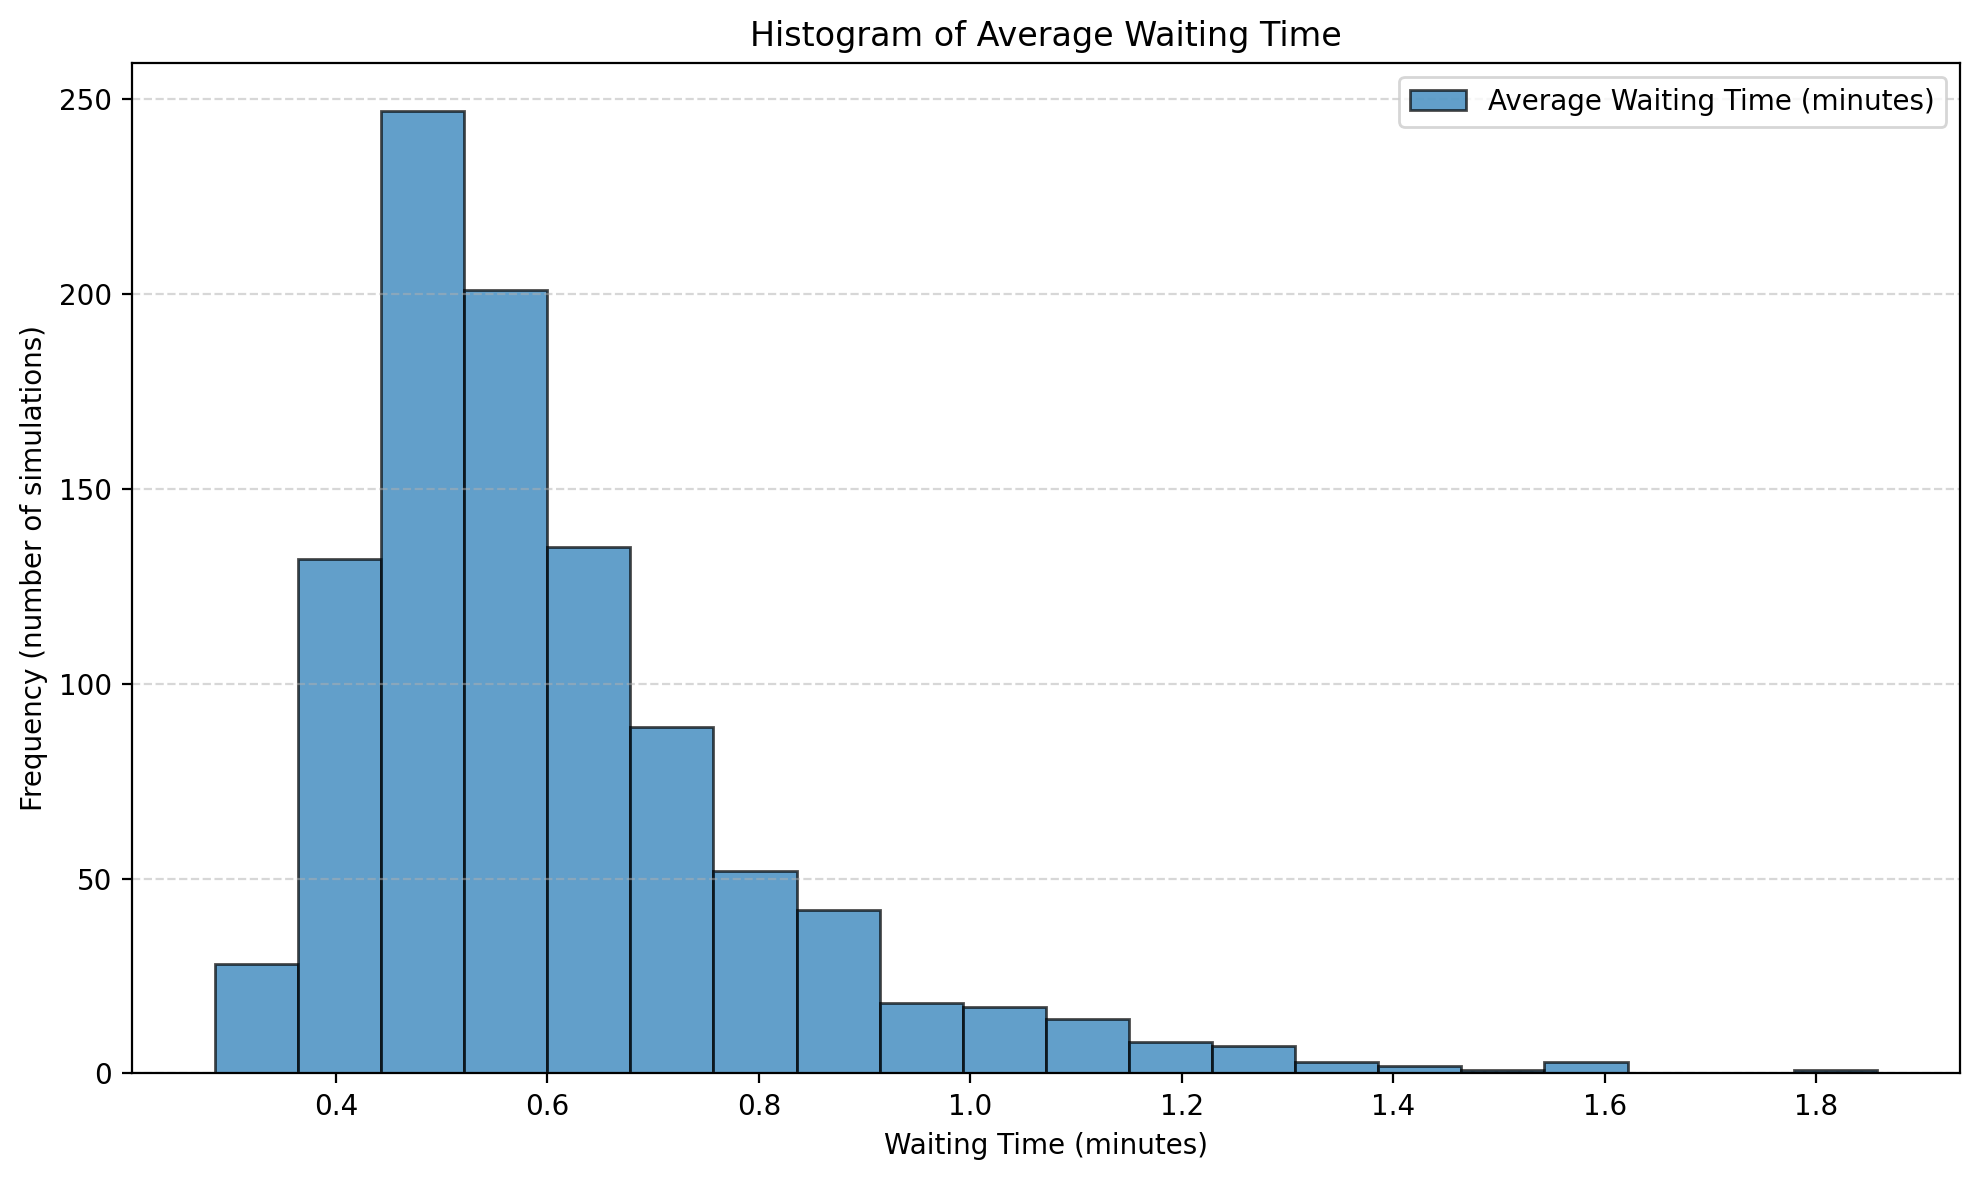

In [8]:
plot_histogram_of_simulation_results(n=1000)

In [9]:

# Queue class

class Queue:
    """
    A queue class for the airport simulation.
    The queue tracks the number of people in line, whether someone is being served
    and the service time distribution.
    """
    def __init__(self, service_time_dist, schedule, extra_security_queue, p_screening = 0.03):
        self.line_length = 0
        self.currently_serving = None
        self.service_time_dist = service_time_dist
        self.schedule = schedule
        self.extra_security_queue = extra_security_queue
        self.waiting = []
        self.waiting_time = []
        self.p_screening = p_screening

    def add_person(self, current_time):
        """add a person to the queue"""
        self.line_length += 1
        self.waiting.append(current_time)
        if not self.currently_serving:
            self.start_service(current_time)

    def start_service(self, current_time):
        """start serving the next person in line"""
        if self.line_length > 0:
            self.line_length -= 1
            self.waiting_time.append(current_time - self.waiting[0])
            self.waiting = self.waiting[1:]
            self.currently_serving = True
            service_time = self.service_time_dist()
            self.schedule.add_event_after(service_time, "service_complete", self.complete_service)


    def complete_service(self):
        """complete the service of the current person"""
        # there is a 3% chance of being chosen for extra screening
        if np.random.rand() < self.p_screening:
            # if chosen for extra screening, add to extra security queue
            self.extra_security_queue.add_queue(self)
        else:
            self.finish_service()

    def finish_service(self):
        """finish the service of the current person"""
        self.currently_serving = None
        self.start_service(self.schedule.time)

    def is_busy(self):
        """getter to check if the queue is busy"""
        return self.currently_serving is not None

    def __lt__(self, other):
        """less than operator for priority queue based on line length"""
        load = self.line_length + (1 if self.is_busy() else 0)
        other_load = other.line_length + (1 if other.is_busy() else 0)
        return load < other_load


class ExtraSecurityQueue(Queue):
    """Extra security queue class for the airport simulation.
    The extra security queue tracks the check-in queues that have passengers needing extra screening.
    """
    def __init__(self, service_time_dist, schedule):
        super().__init__(service_time_dist, schedule, None)
        self.queues = []


    def add_queue(self, queue):
        """add a check-in queue to the extra security queue"""
        self.waiting.append(self.schedule.time)
        self.queues.append(queue)
        if not self.currently_serving:
            self.start_service(self.schedule.time)


    def start_service(self, current_time):
        """start serving the next queue in line"""
        if self.waiting:
            self.currently_serving = True
            current_time = self.schedule.time
            self.waiting_time.append(current_time - self.waiting.pop(0))

            service_time = self.service_time_dist()
            self.schedule.add_event_after(service_time, "Extra_screening_complete", self.complete_service)

    def complete_service(self):
        """complete the service of the current queue"""
        self.currently_serving = False
        self.queues.pop(0).finish_service()
        self.start_service(self.schedule.time)



# Airport Class
class Airport:
    """
    The Airport class for the airport simulation.
    The airport has multiple queues for check-in, security, and boarding.
    It also has distributions for arrival rates and service times.

    The extra security queue is a special queue for passengers who need additional screening.

    """
    def __init__(self, schedule, service_time_dist, exta_security_service_time_dist,
                 arrival_rate_dist, arrival_count_dist, num_checkin_queues=3, num_security_queues=3, p_screening=0.03):
        self.schedule = schedule

        self.extra_security_queue = ExtraSecurityQueue(exta_security_service_time_dist, schedule)
        self.checkin_queues = []
        for _ in range(num_checkin_queues):
            heapq.heappush(self.checkin_queues, Queue(service_time_dist, schedule, self.extra_security_queue, p_screening=p_screening))

        self.arrival_rate_dist = arrival_rate_dist
        self.arrival_count_dist = arrival_count_dist
        self.schedule.add_event_after(0, "passenger_arrival", self.passenger_arrival) # Schedule the first passenger arrival



    def passenger_arrival(self):
        """Handle passenger arrival event"""
        count = self.arrival_count_dist()
        # for all arriving passengers, assign them to the shortest check-in queue
        heapq.heapify(self.checkin_queues)  # Re-establish heap property
        shortest_queue = heapq.heappop(self.checkin_queues)
        for _ in range(count):
            shortest_queue.add_person(self.schedule.time)
        heapq.heappush(self.checkin_queues, shortest_queue)

        # Schedule the next passenger arrival
        next_arrival_time = self.arrival_rate_dist()
        self.schedule.add_event_after(next_arrival_time, "passenger_arrival", self.passenger_arrival)



100%|██████████| 1000/1000 [00:26<00:00, 37.19it/s]


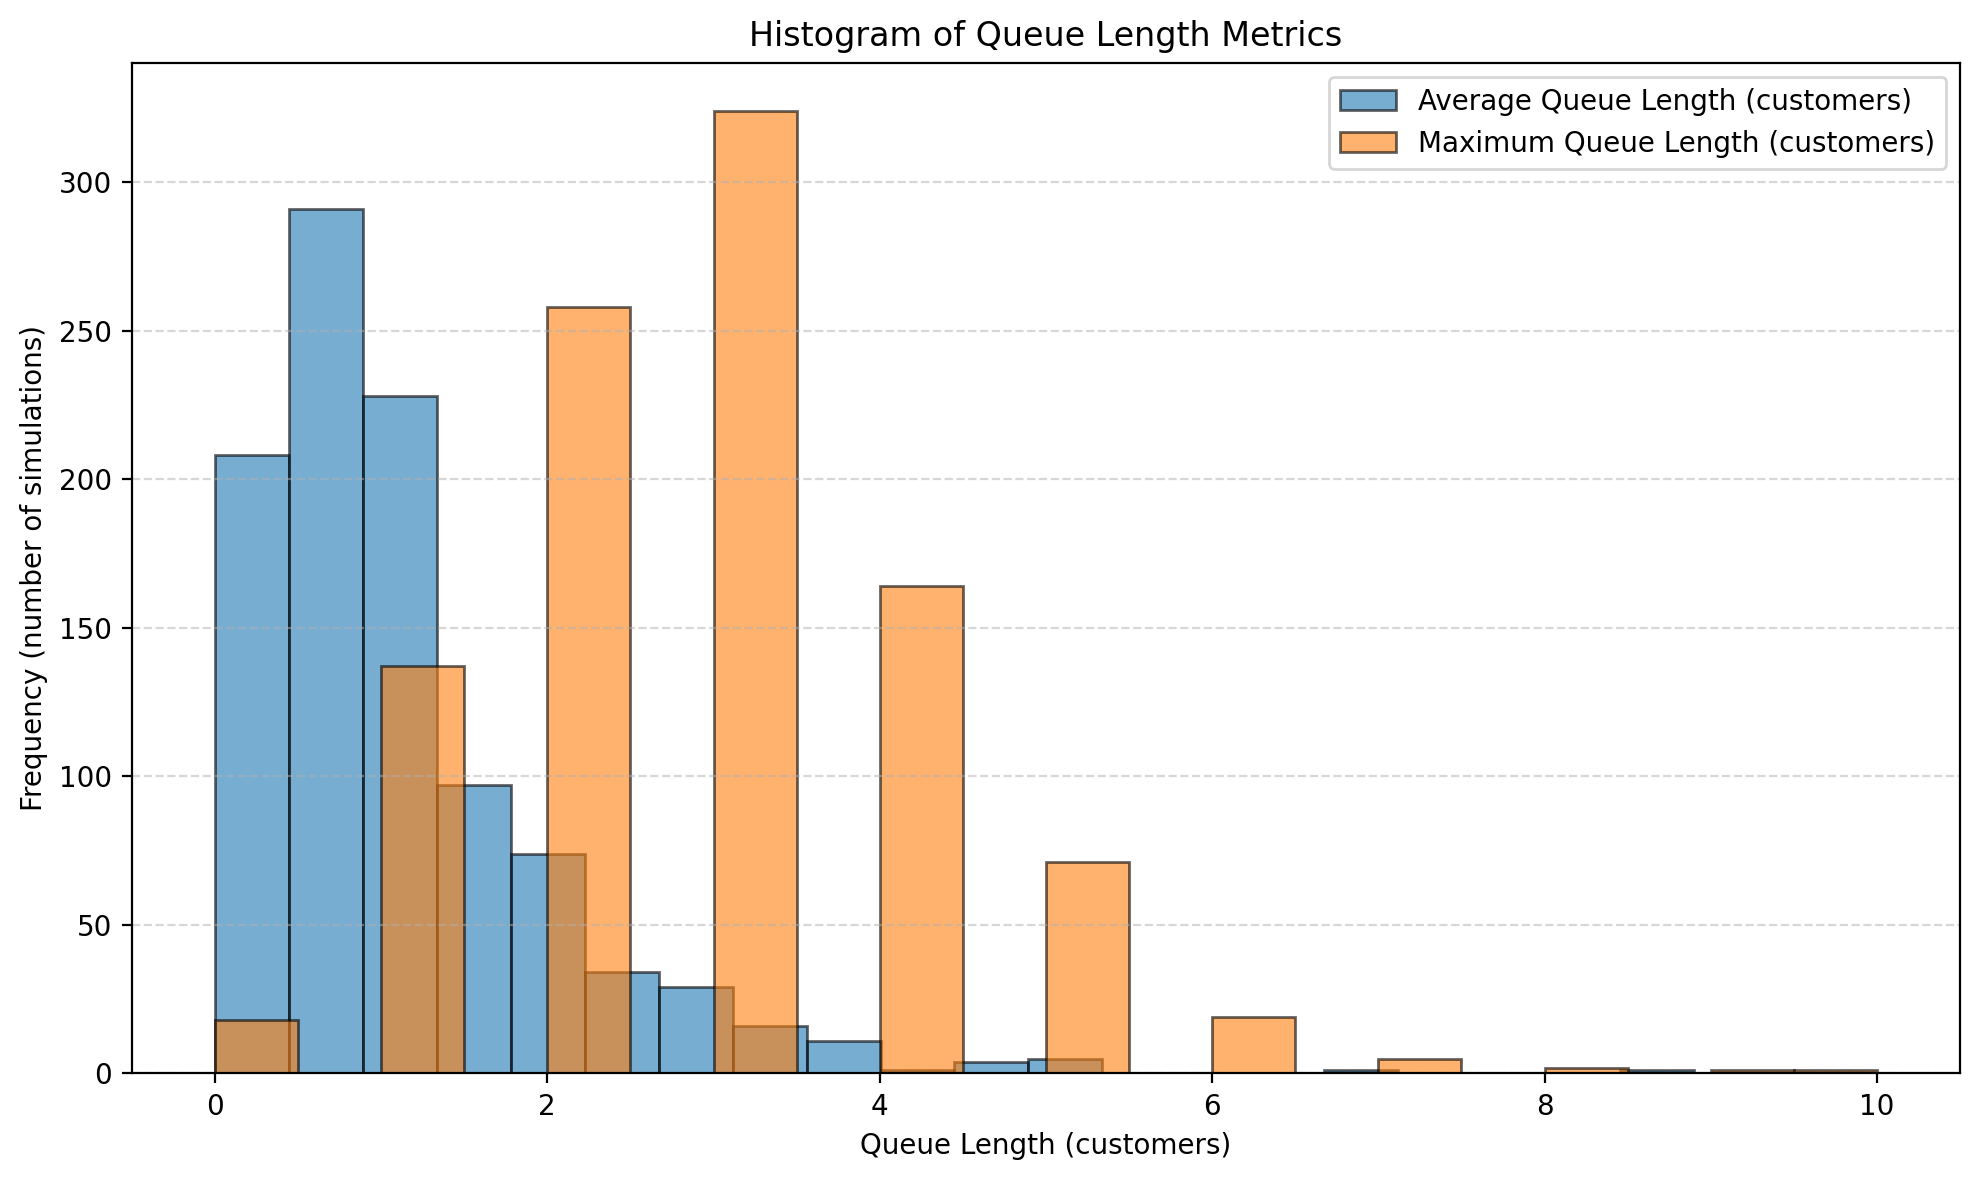

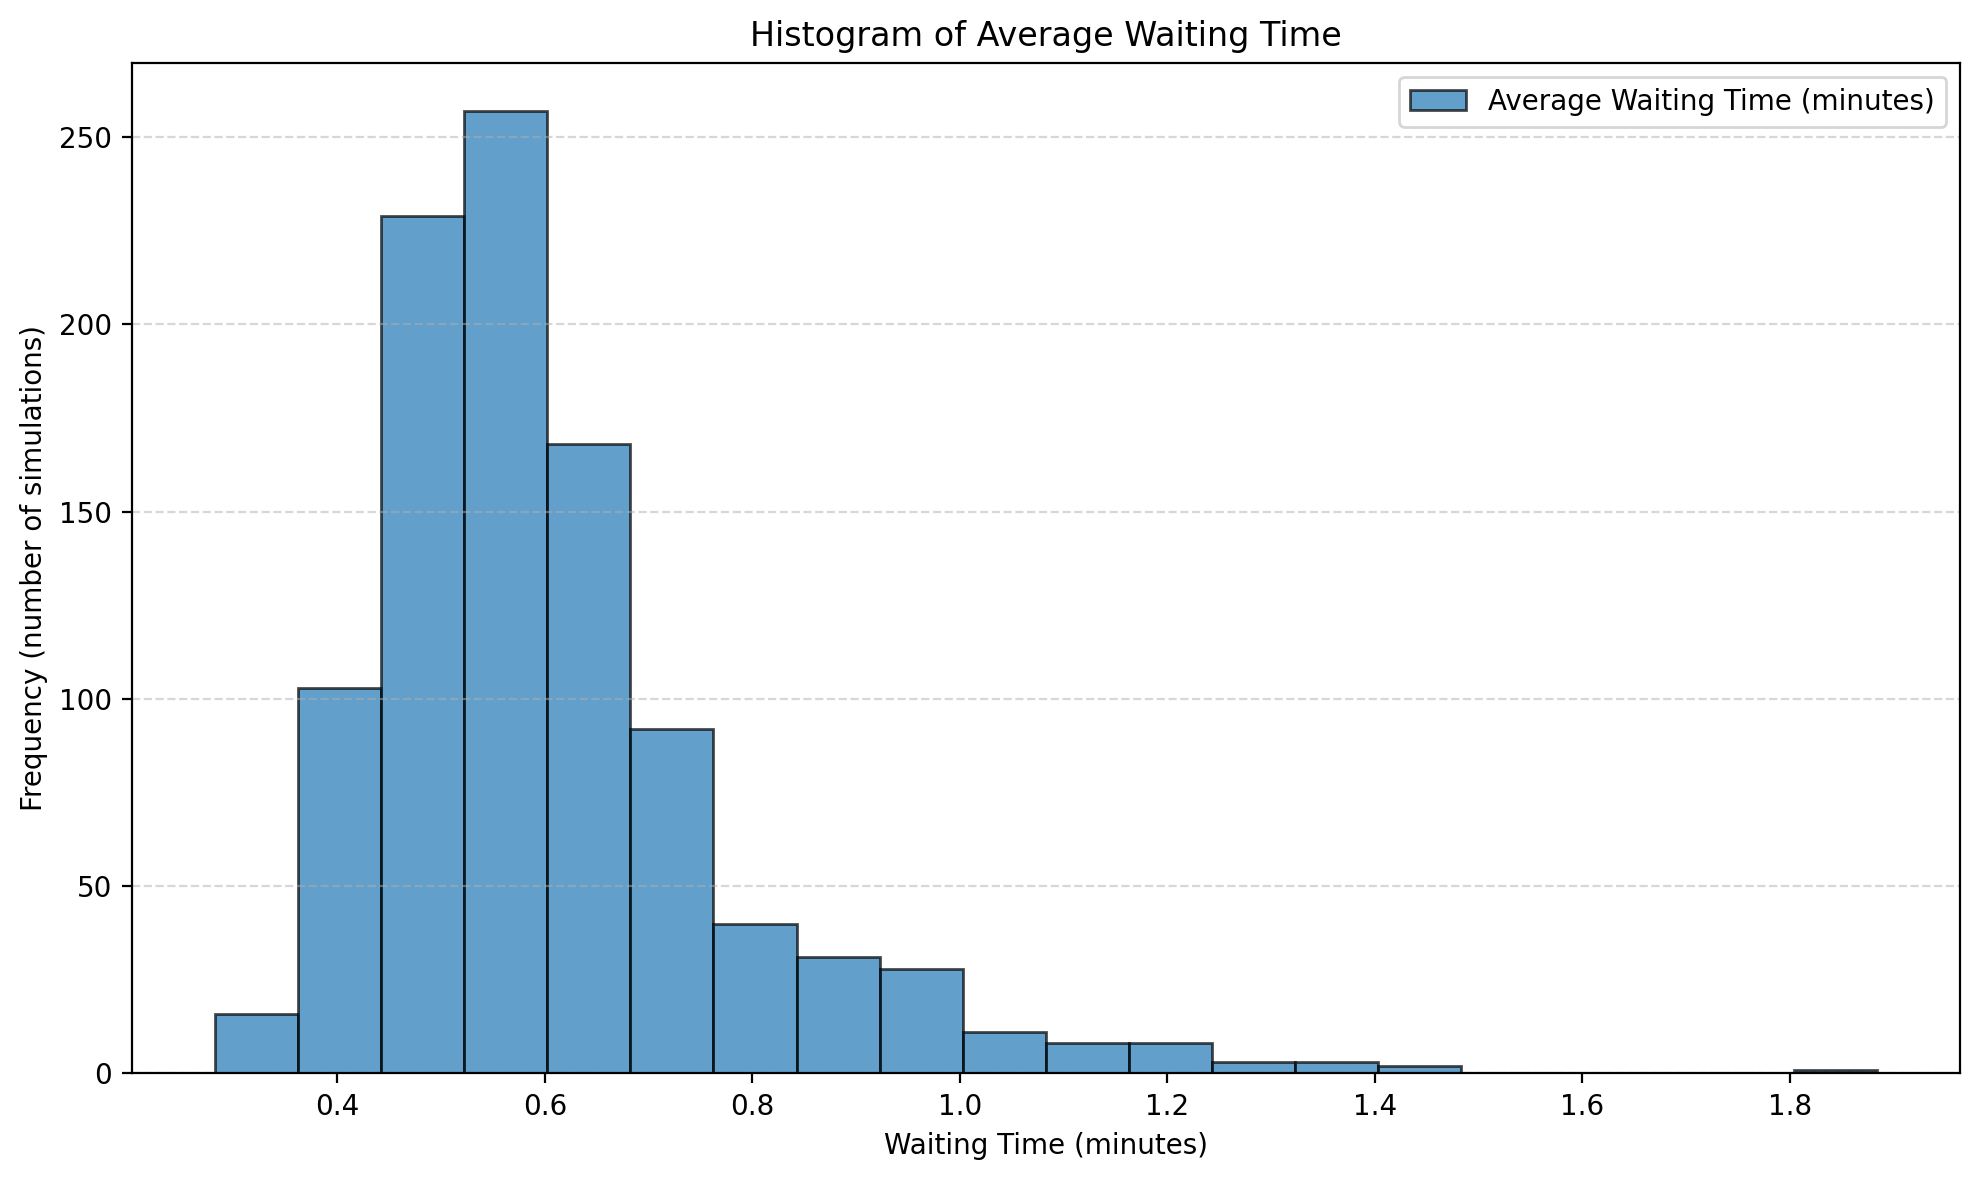

In [10]:
plot_histogram_of_simulation_results(1000, p_screening=0)

100%|██████████| 1000/1000 [00:30<00:00, 33.21it/s]


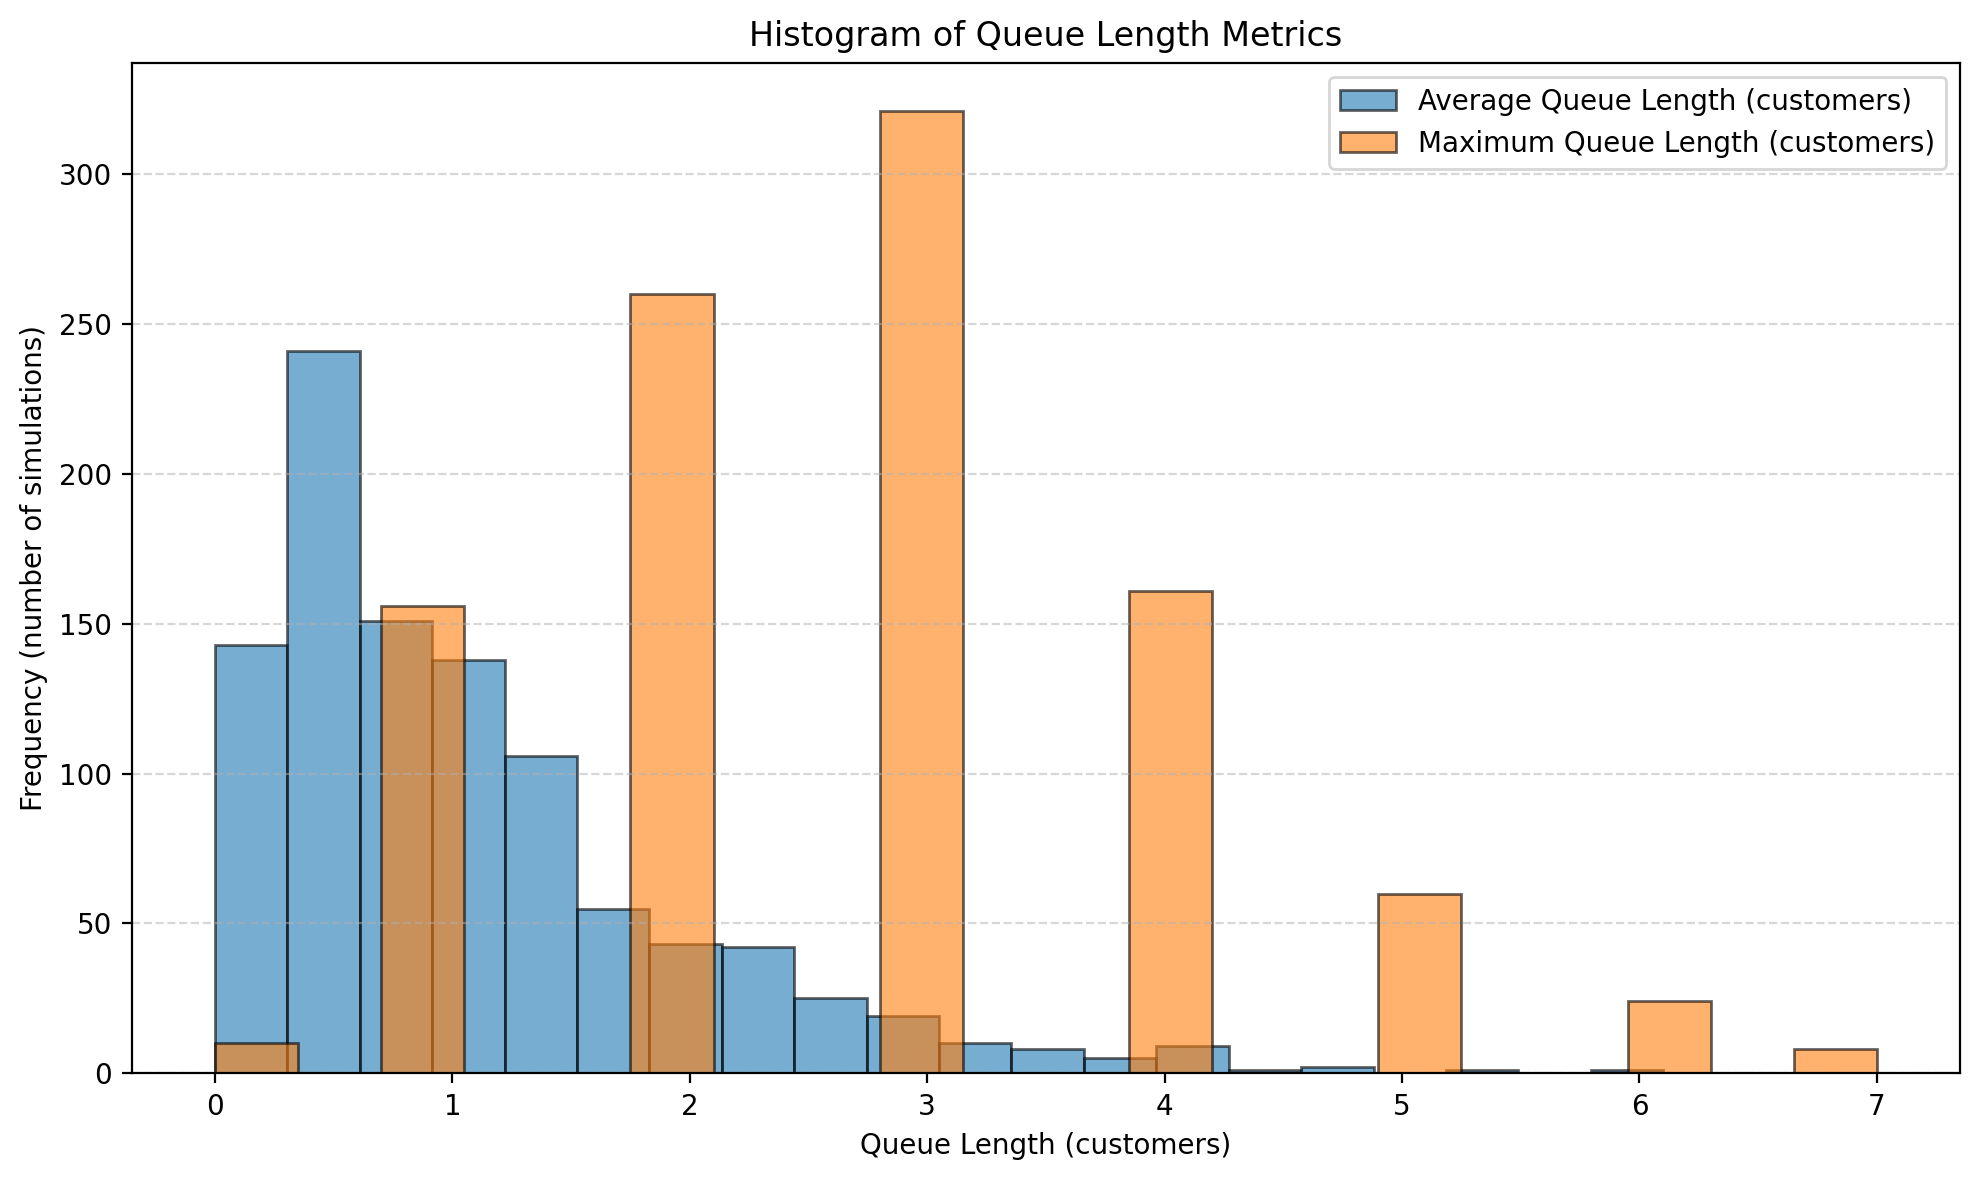

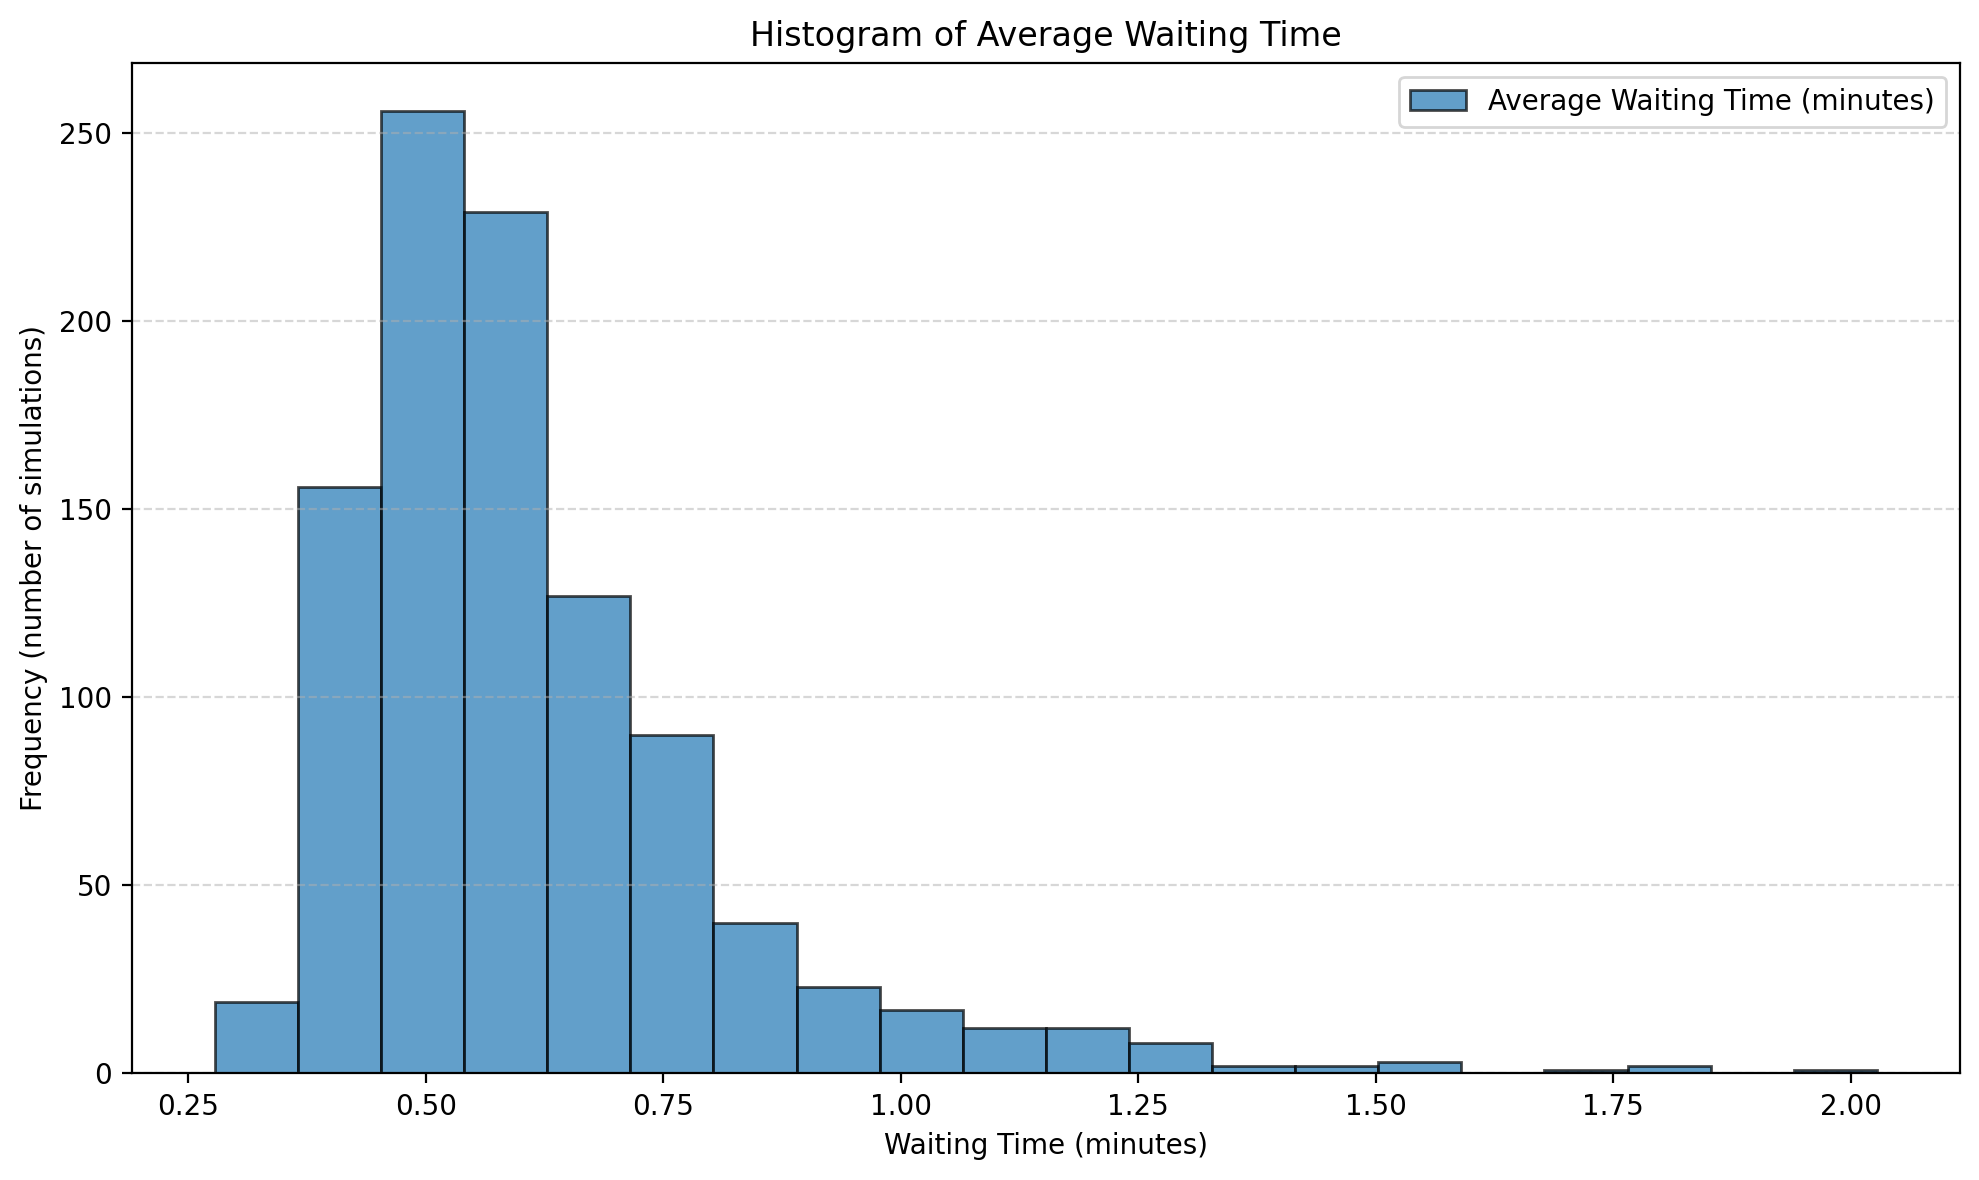

In [11]:
plot_histogram_of_simulation_results(1000, mu_2=0, sigma_2=0)

In [12]:
# we want to see the effect of changing the queue length on the average waiting time
# we will create a scatter plot that shows the average waiting time vs the number of queues
# and the 95% confidence interval for each point
def waiting_time_vs_num_queues(n_simulations=500, max_queues=20):
    """We want to see the effect of changing the number of queues on the average waiting time.
    inputs:
        n_simulations: int, number of simulations to run for each number of queues
        max_queues: int, maximum number of queues to test
    returns:
        num_queues_list: list, list of number of queues tested
        avg_waiting_times: list, list of average waiting times for each number of queues
        ci_lower: list, list of lower bounds of 95% confidence intervals for each number of queues
        ci_upper: list, list of upper bounds of 95% confidence intervals for each number of queues
    """
    num_queues_list = list(range(1, max_queues + 1))
    avg_waiting_times = []
    avg_queue_lengths = []
    max_queue_lengths = []
    ci_lower = []
    ci_upper = []


    for num_queues in num_queues_list:
        avg_queue_length, max_queue_length, waiting_times = run_n_simulations(n_simulations, num_queues=num_queues, count_dist=[[1],[1]])

        # waiting time
        mean_waiting_time = np.mean(waiting_times)
        avg_waiting_times.append(mean_waiting_time)

        # Calculate 95% confidence interval
        sem = sts.sem(waiting_times)
        ci = sem * sts.t.ppf((1 + 0.95) / 2., n_simulations - 1)
        ci_lower.append(mean_waiting_time - ci)
        ci_upper.append(mean_waiting_time + ci)


        # queue length
        mean_queue_length = np.mean(avg_queue_length)
        avg_queue_lengths.append(mean_queue_length)

        # max queue length
        mean_max_queue_length = np.mean(max_queue_length)
        max_queue_lengths.append(mean_max_queue_length)


    return num_queues_list, avg_waiting_times, ci_lower, ci_upper, avg_queue_lengths, max_queue_lengths


In [13]:
num_queues_list, avg_waiting_times, ci_lower, ci_upper, avg_queue_lengths, max_queue_lengths = waiting_time_vs_num_queues(n_simulations=30, max_queues=20)



100%|██████████| 30/30 [00:00<00:00, 35.35it/s]


Queues: 1, Theoretical Waiting Time: inf
Queues: 2, Theoretical Waiting Time: inf
Queues: 3, Theoretical Waiting Time: inf
Queues: 4, Theoretical Waiting Time: inf
Queues: 5, Theoretical Waiting Time: inf
Queues: 6, Theoretical Waiting Time: 0.16850378131308022
Queues: 7, Theoretical Waiting Time: 0.05061548428895368
Queues: 8, Theoretical Waiting Time: 0.020169191231485115
Queues: 9, Theoretical Waiting Time: 0.009021872071996798
Queues: 10, Theoretical Waiting Time: 0.004303300309163358
Queues: 11, Theoretical Waiting Time: 0.002140164918936327
Queues: 12, Theoretical Waiting Time: 0.001096746255094844
Queues: 13, Theoretical Waiting Time: 0.0005751065333416027
Queues: 14, Theoretical Waiting Time: 0.00030720453022554294
Queues: 15, Theoretical Waiting Time: 0.0001666530846743491
Queues: 16, Theoretical Waiting Time: 9.161141035185593e-05
Queues: 17, Theoretical Waiting Time: 5.094735805293278e-05
Queues: 18, Theoretical Waiting Time: 2.862712419078468e-05
Queues: 19, Theoretical Wai

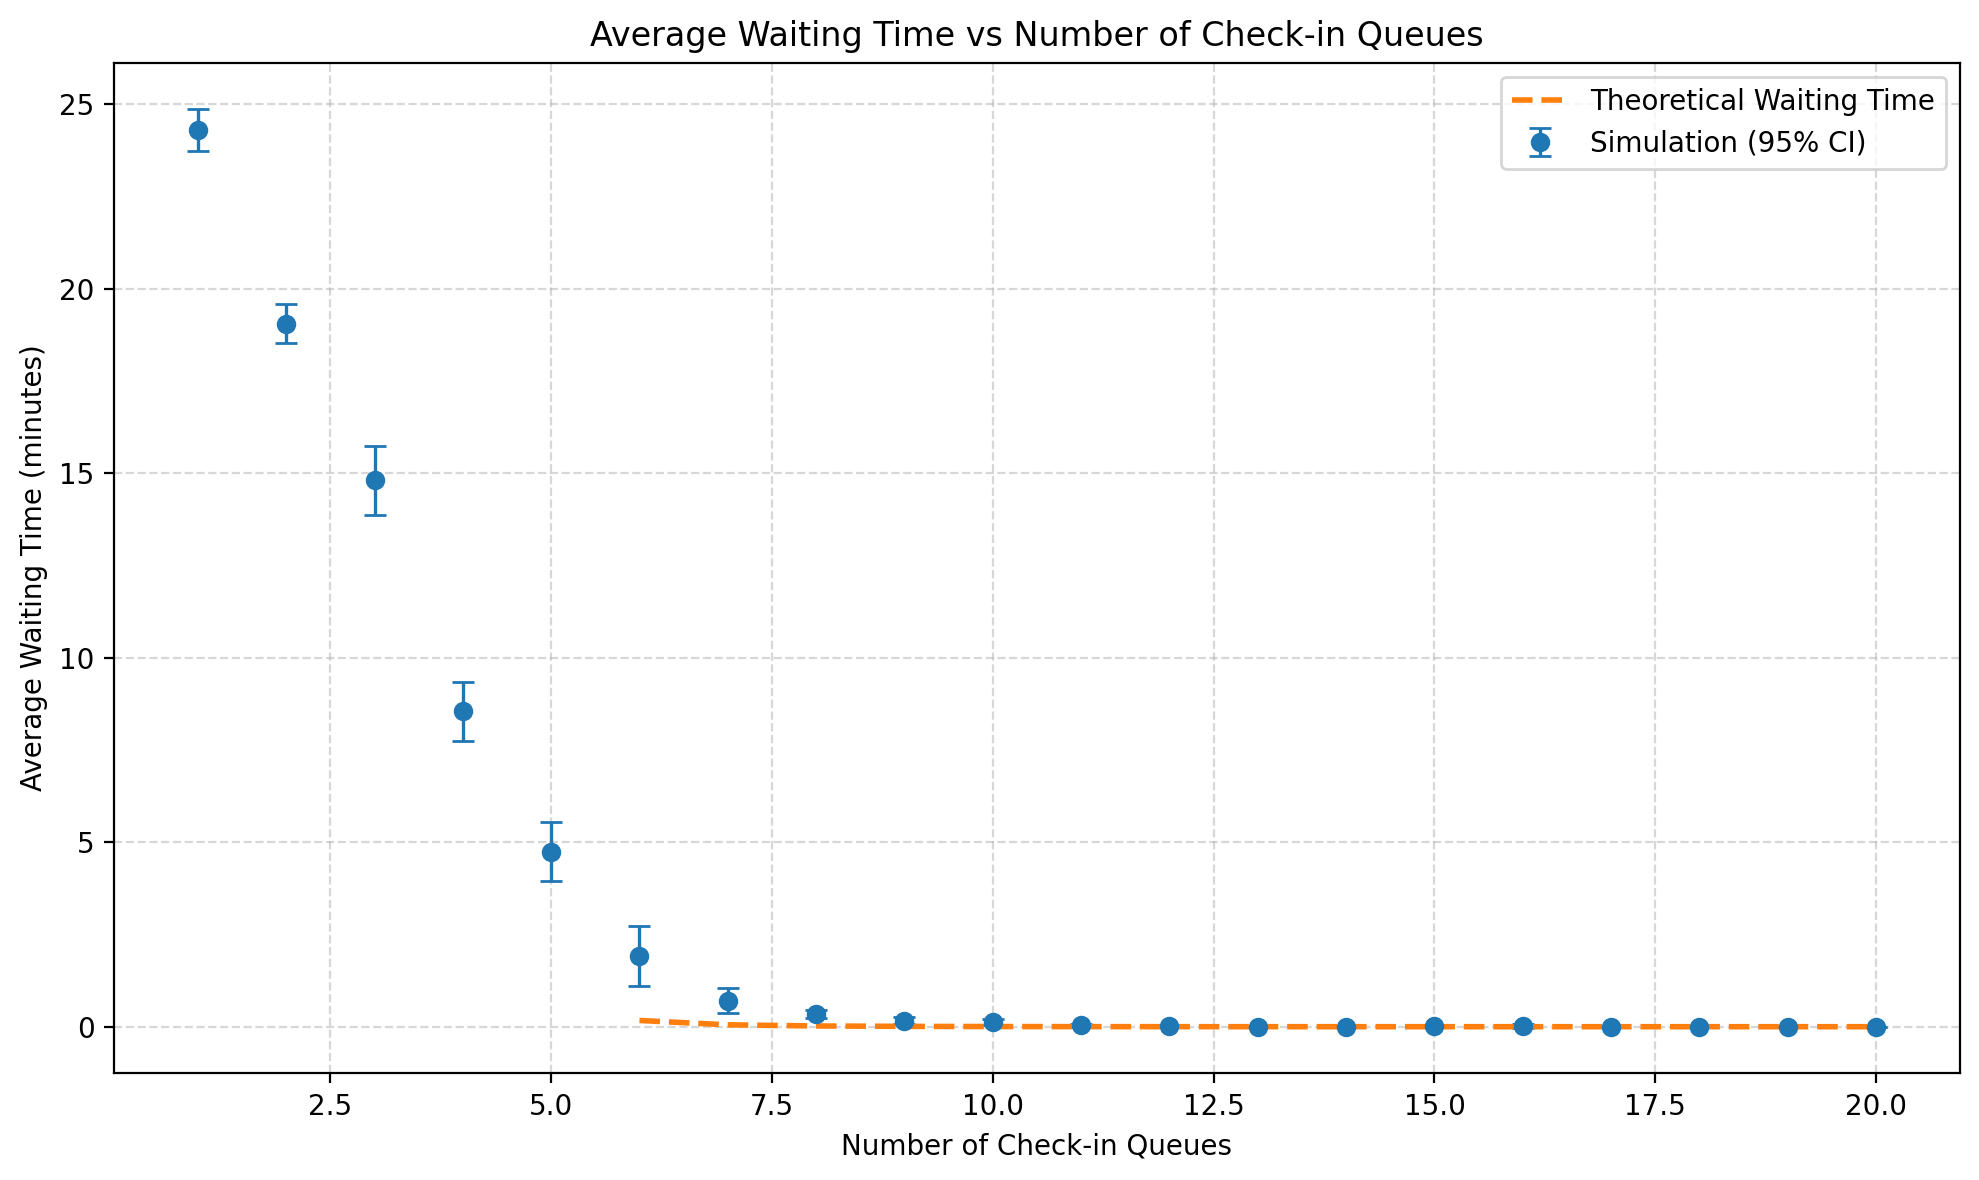

In [14]:
# error plot bar
# regression line


def waiting_time_theoritical(num_queues, L=10, mu=0.5, sigma=1/6):
    # using M/G/c queueing theory
    rho = (L * mu) / num_queues
    if rho >= 1:
        return float('inf')  # System is unstable
    # Approximate average waiting time in queue (Wq) using Pollaczek-Khinchine formula
    ca2 = 1  # Coefficient of variation for inter-arrival times (Poisson process)
    cs2 = (sigma / mu) ** 2  # Coefficient of variation for
    Wq = (rho ** (np.sqrt(2 * (num_queues + 1)) - 1) / (num_queues * (1 - rho))) * ((ca2 + cs2) / 2) * mu
    return Wq


for i in range(1,20):
    print(f"Queues: {i}, Theoretical Waiting Time: {waiting_time_theoritical(i)}")

plt.figure(figsize=(10, 6), dpi=200)

# Error bars (simulation results)
plt.errorbar(
    num_queues_list,
    avg_waiting_times,
    yerr=[
        np.array(avg_waiting_times) - np.array(ci_lower),
        np.array(ci_upper) - np.array(avg_waiting_times),
    ],
    fmt="o",
    markersize=6,
    capsize=4,
    elinewidth=1.2,
    label="Simulation (95% CI)"
)

# Theoretical curve
plt.plot(
    num_queues_list,
    [waiting_time_theoritical(n) for n in num_queues_list],
    linestyle="--",
    linewidth=2,
    label="Theoretical Waiting Time"
)

# Labels and title with units
plt.title("Average Waiting Time vs Number of Check-in Queues")
plt.xlabel("Number of Check-in Queues")
plt.ylabel("Average Waiting Time (minutes)")

# Improve readability
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()

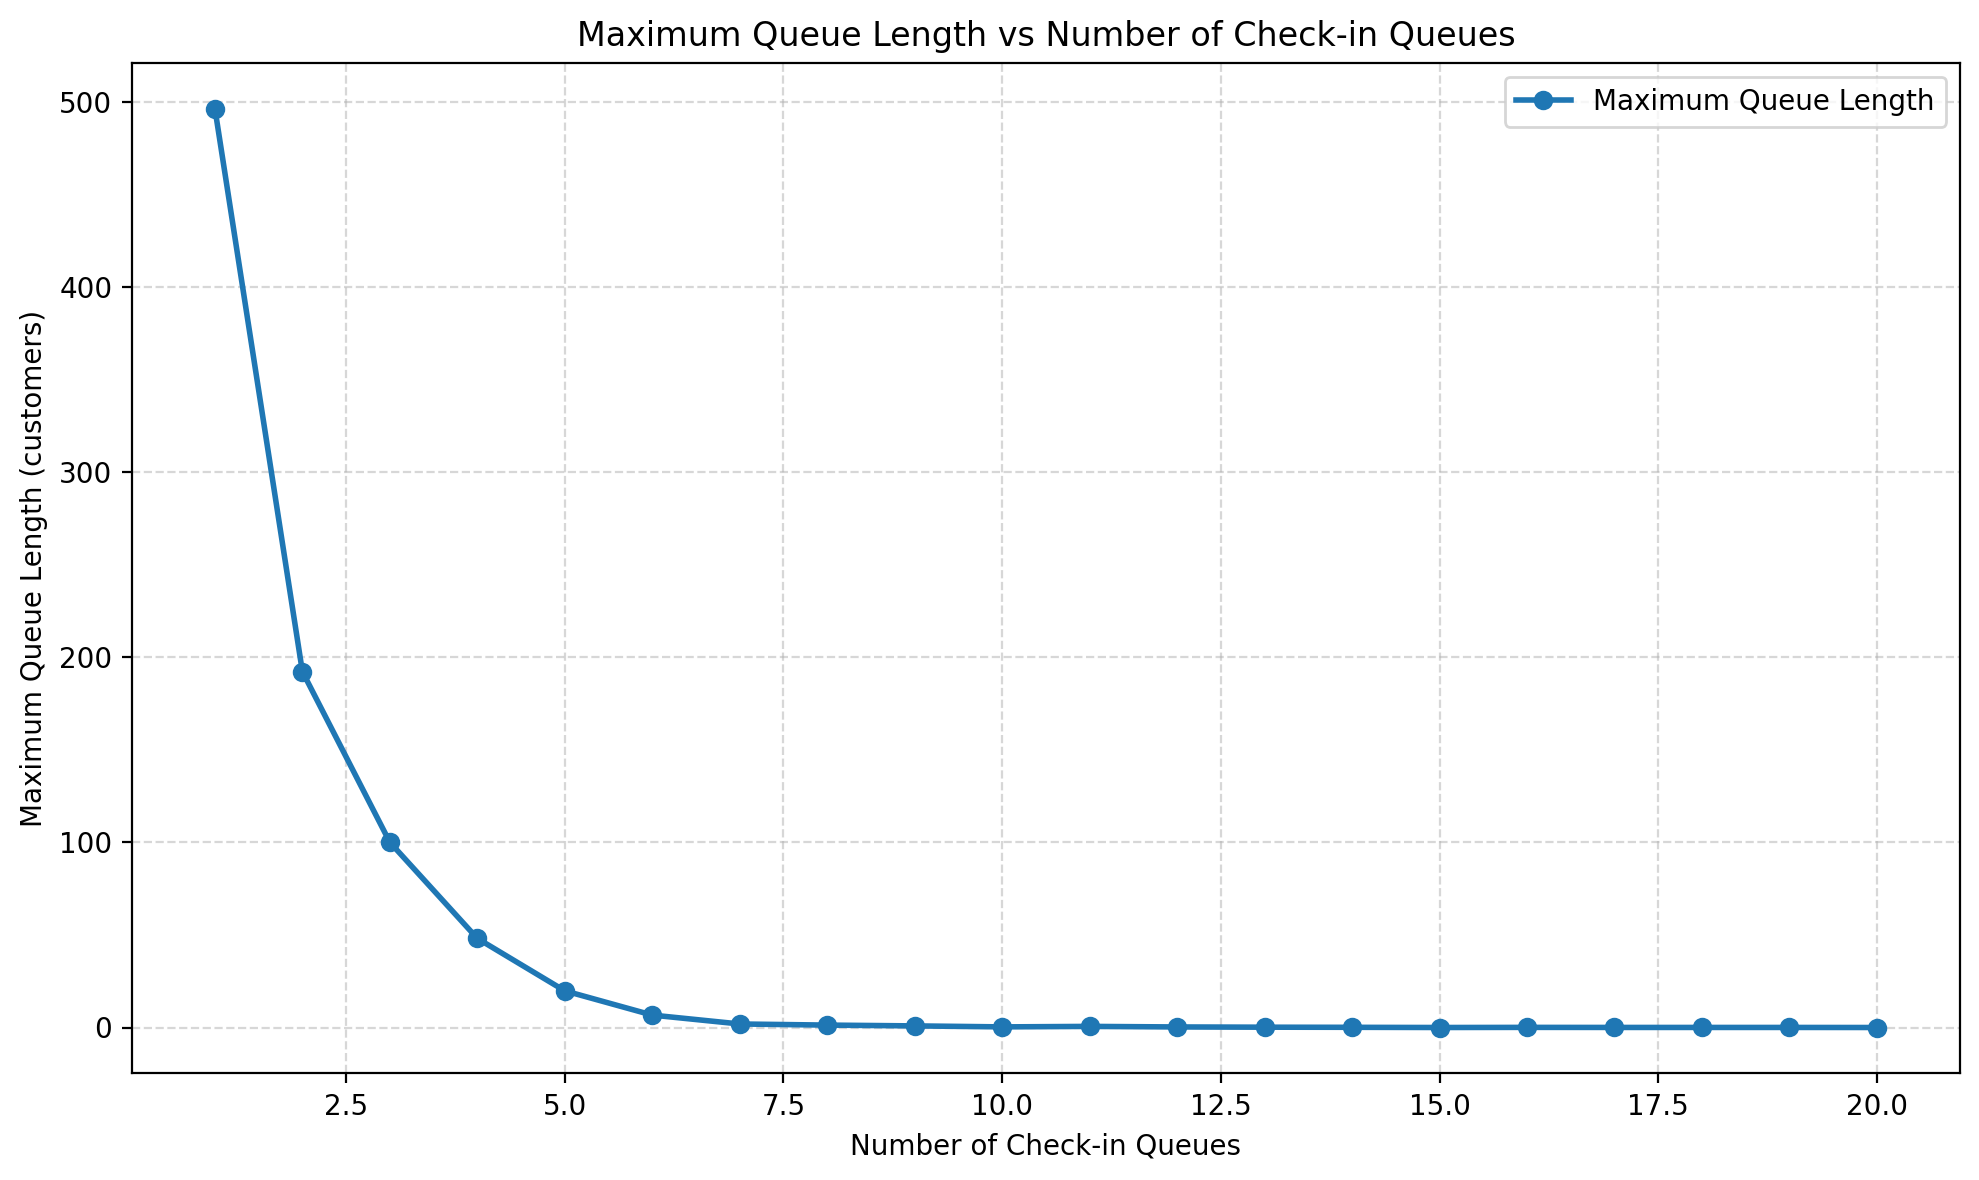

In [15]:
# max queue length plot
plt.figure(figsize=(10, 6), dpi=200)

plt.plot(
    num_queues_list,
    max_queue_lengths,
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=6,
    label="Maximum Queue Length"
)

plt.title("Maximum Queue Length vs Number of Check-in Queues")
plt.xlabel("Number of Check-in Queues")
plt.ylabel("Maximum Queue Length (customers)")

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()


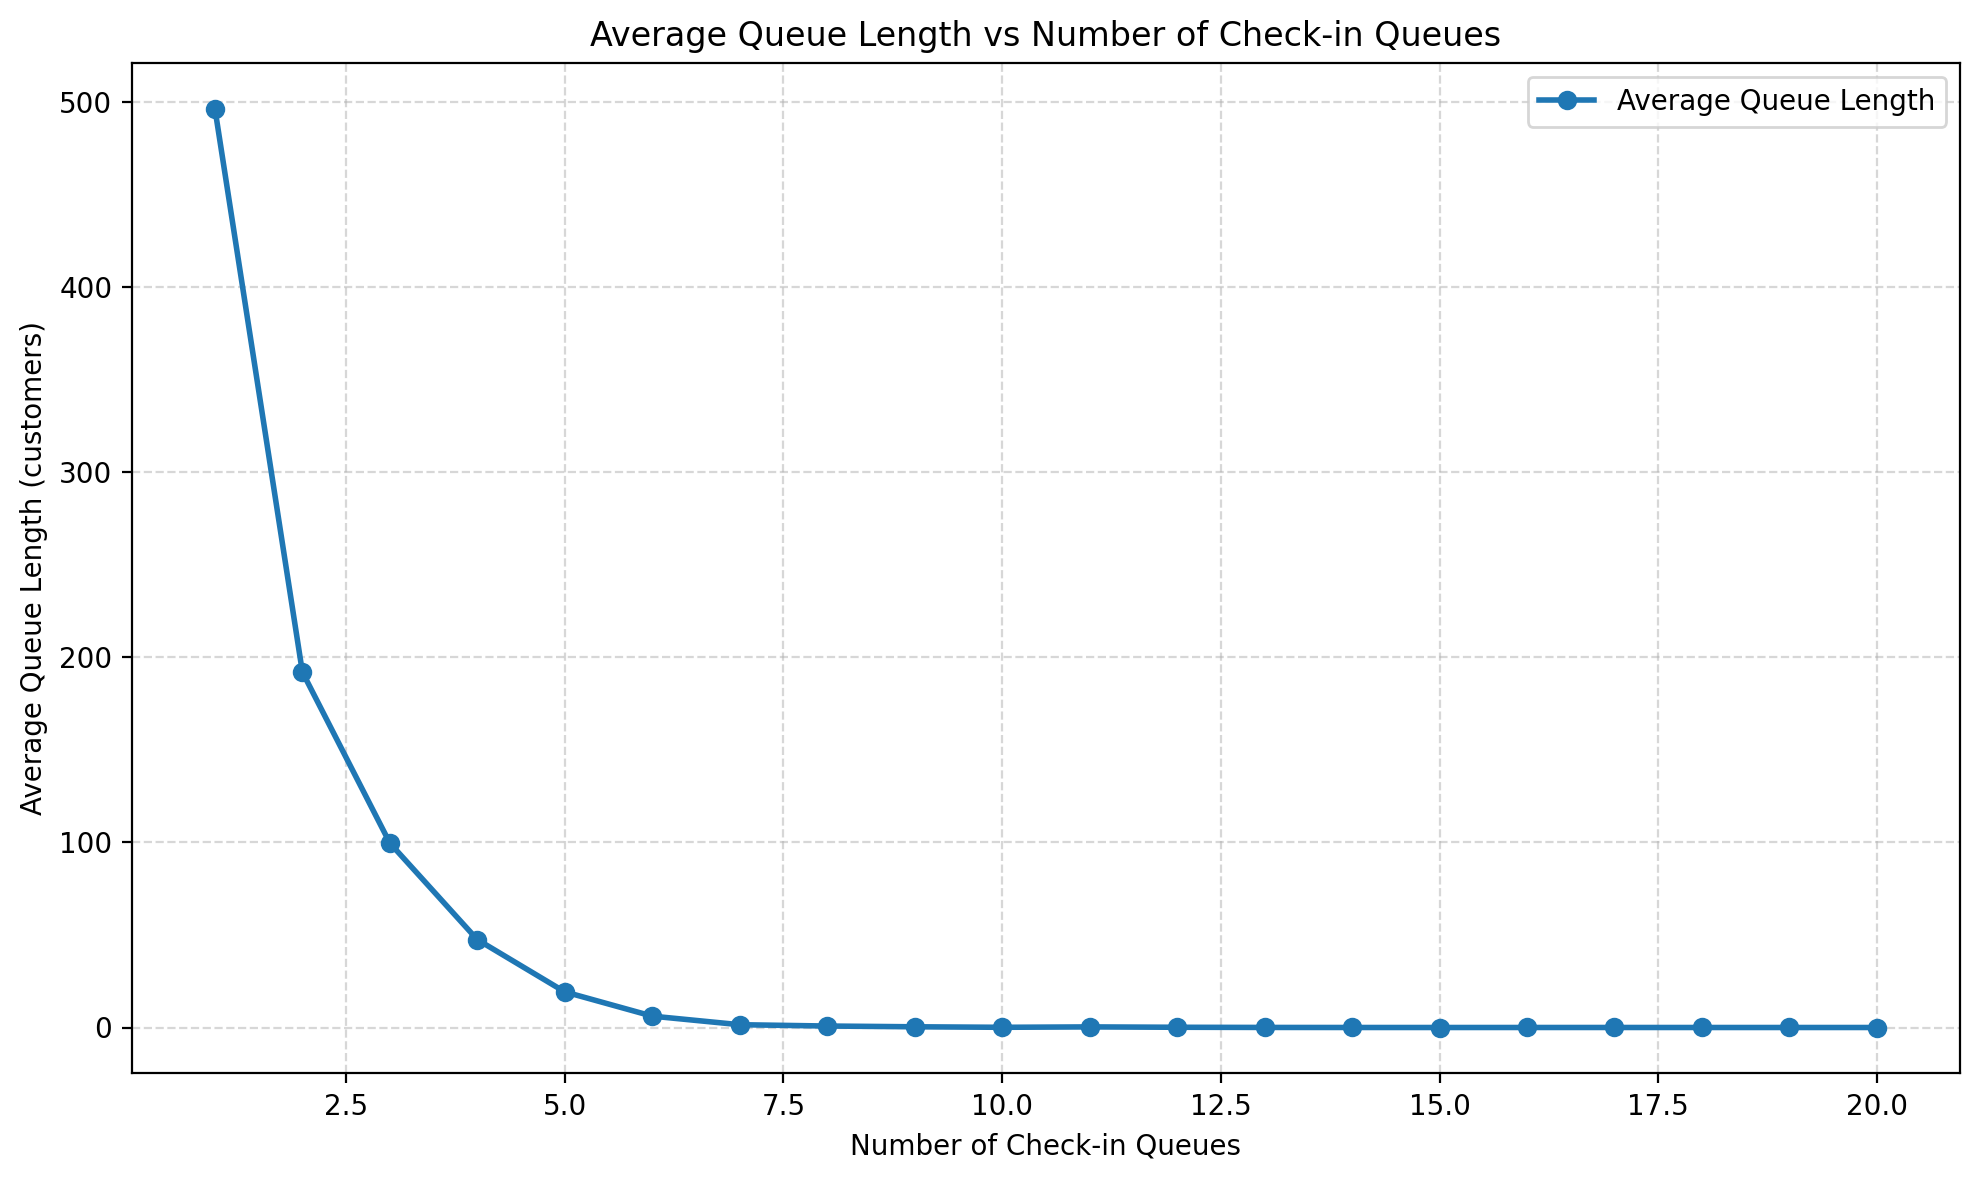

In [16]:
# avg queue length plot
plt.figure(figsize=(10, 6), dpi=200)

plt.plot(
    num_queues_list,
    avg_queue_lengths,
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=6,
    label="Average Queue Length"
)

plt.title("Average Queue Length vs Number of Check-in Queues")
plt.xlabel("Number of Check-in Queues")
plt.ylabel("Average Queue Length (customers)")

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()
